# Introduction

The goal of this document is to guide the reader through the process of creating a good model for predicting on a specific data set. The data set in this case is company data which assesses the quality of the online advertisment campaign and wants to predict wheter a customer subscribes or not. 

## Imports

To assess this certain python packages are needed which are loaded below.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

## Description of data set

A company wants to assess the quality of their online advertisement campaign. Online users are the main interest
in this campaign. The users see a web banner during their browsing activity. For each user, they want to be able
to predict whether they subscribe to the advertised product through the advertisement banner, based on the
information they have about them. To subscribe, the user has to click on the banner and then subscribe to the
service. The target variable name is subscription

In [3]:
train = pd.read_csv('data/MLUnige2023_subscriptions_train.csv', index_col='Id', na_values='na', header=0).astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'bool', 'subscription':'bool', 'day':'category', 'month':'category'})
test = pd.read_csv('data/MLUnige2023_subscriptions_test.csv', index_col='Id', na_values='na', header=0).astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'bool', 'day':'category', 'month':'category'})
train.day = pd.Categorical(train.day, ordered=True)
test.day = pd.Categorical(test.day, ordered=True)
train.month = pd.Categorical(train.month, ordered=True)
test.month = pd.Categorical(test.month, ordered=True)
train.head()

,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4,subscription
Id,,,,,,,,,,,,,,,,,
0,28,freelance,married,grad_school,smartphone,4,2,26.80,3,4,196,failure,False,False,True,True,True
1,48,industrial_worker,married,university,smartphone,30,4,13.05,1,1,79,success,False,False,False,True,True
2,27,teacher,married,university,smartphone,14,7,8.10,3,0,-1,NaN,False,True,True,True,False
3,44,unemployed,divorced,university,smartphone,13,5,7.10,2,1,369,other,False,False,True,True,False
4,29,manager,single,grad_school,smartphone,26,4,15.90,2,2,143,success,False,False,False,True,True


# Exploratory data analysis (EDA) and feature engineering (FE)

## EDA

* https://towardsdatascience.com/exploratory-data-analysis-in-python-a-step-by-step-process-d0dfa6bf94ee
* https://www.digitalocean.com/community/tutorials/exploratory-data-analysis-python
* https://experienceleague.adobe.com/docs/experience-platform/data-science-workspace/jupyterlab/eda-notebook.html?lang=en
* https://www.datacamp.com/tutorial/categorical-data
* https://seaborn.pydata.org/tutorial/categorical.html


In [4]:
train.shape

(8952, 17)

In [5]:
# Basic information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8952 entries, 0 to 8951
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               8952 non-null   int64   
 1   job               8891 non-null   category
 2   marital           8952 non-null   category
 3   education         8574 non-null   category
 4   device            6902 non-null   category
 5   day               8952 non-null   category
 6   month             8952 non-null   category
 7   time_spent        8952 non-null   float64 
 8   banner_views      8952 non-null   int64   
 9   banner_views_old  8952 non-null   int64   
 10  days_elapsed_old  8952 non-null   int64   
 11  outcome_old       2148 non-null   category
 12  X1                8952 non-null   bool    
 13  X2                8952 non-null   bool    
 14  X3                8952 non-null   bool    
 15  X4                8952 non-null   bool    
 16  subscription      8952 n

In [6]:
categorical_columns = train.select_dtypes(include=["category","bool"])
categorical_columns_names = list(categorical_columns.columns)
numerical_columns = train.select_dtypes(exclude=["category","bool"])
numerical_columns_names = list(numerical_columns)

In [7]:
# Describe numerical data
train.describe()

,age,time_spent,banner_views,banner_views_old,days_elapsed_old
count,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000
mean,41.201743,17.130306,2.540550,0.759160,49.403262
std,11.638321,16.902741,2.824065,2.099277,107.365840
min,18.000000,0.000000,1.000000,0.000000,-1.000000
25%,32.000000,6.100000,1.000000,0.000000,-1.000000
50%,39.000000,11.450000,2.000000,0.000000,-1.000000
75%,49.000000,22.500000,3.000000,0.000000,-1.000000
max,95.000000,245.400000,63.000000,58.000000,854.000000


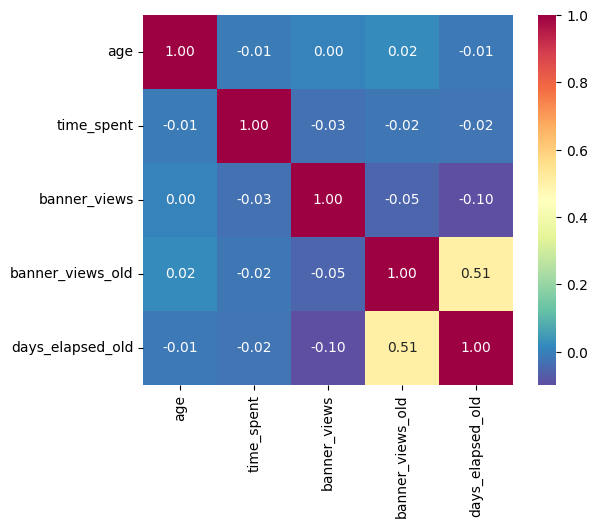

In [8]:
corrmat = numerical_columns.corr(numeric_only=True)
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels= numerical_columns_names, 
                 xticklabels=numerical_columns_names, 
                 cmap="Spectral_r")
plt.show()

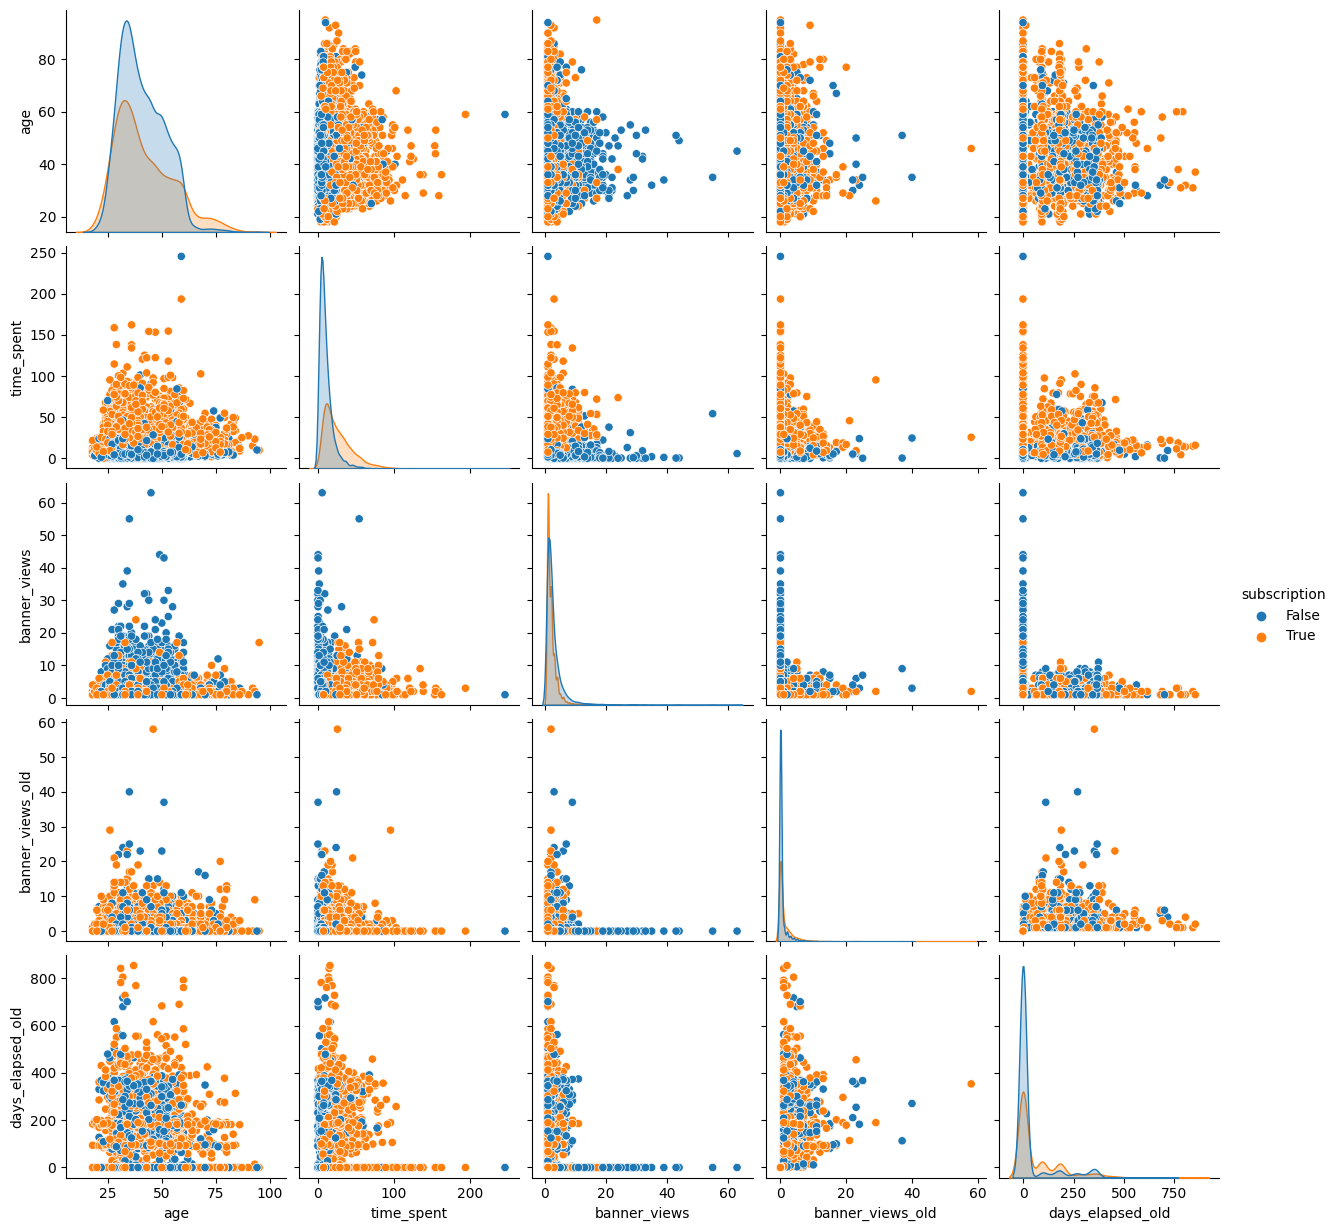

In [20]:
numeric_and_sub = pd.concat([numerical_columns, train.subscription], axis=1)
sns.pairplot(numeric_and_sub, hue = 'subscription', diag_kind='kde')

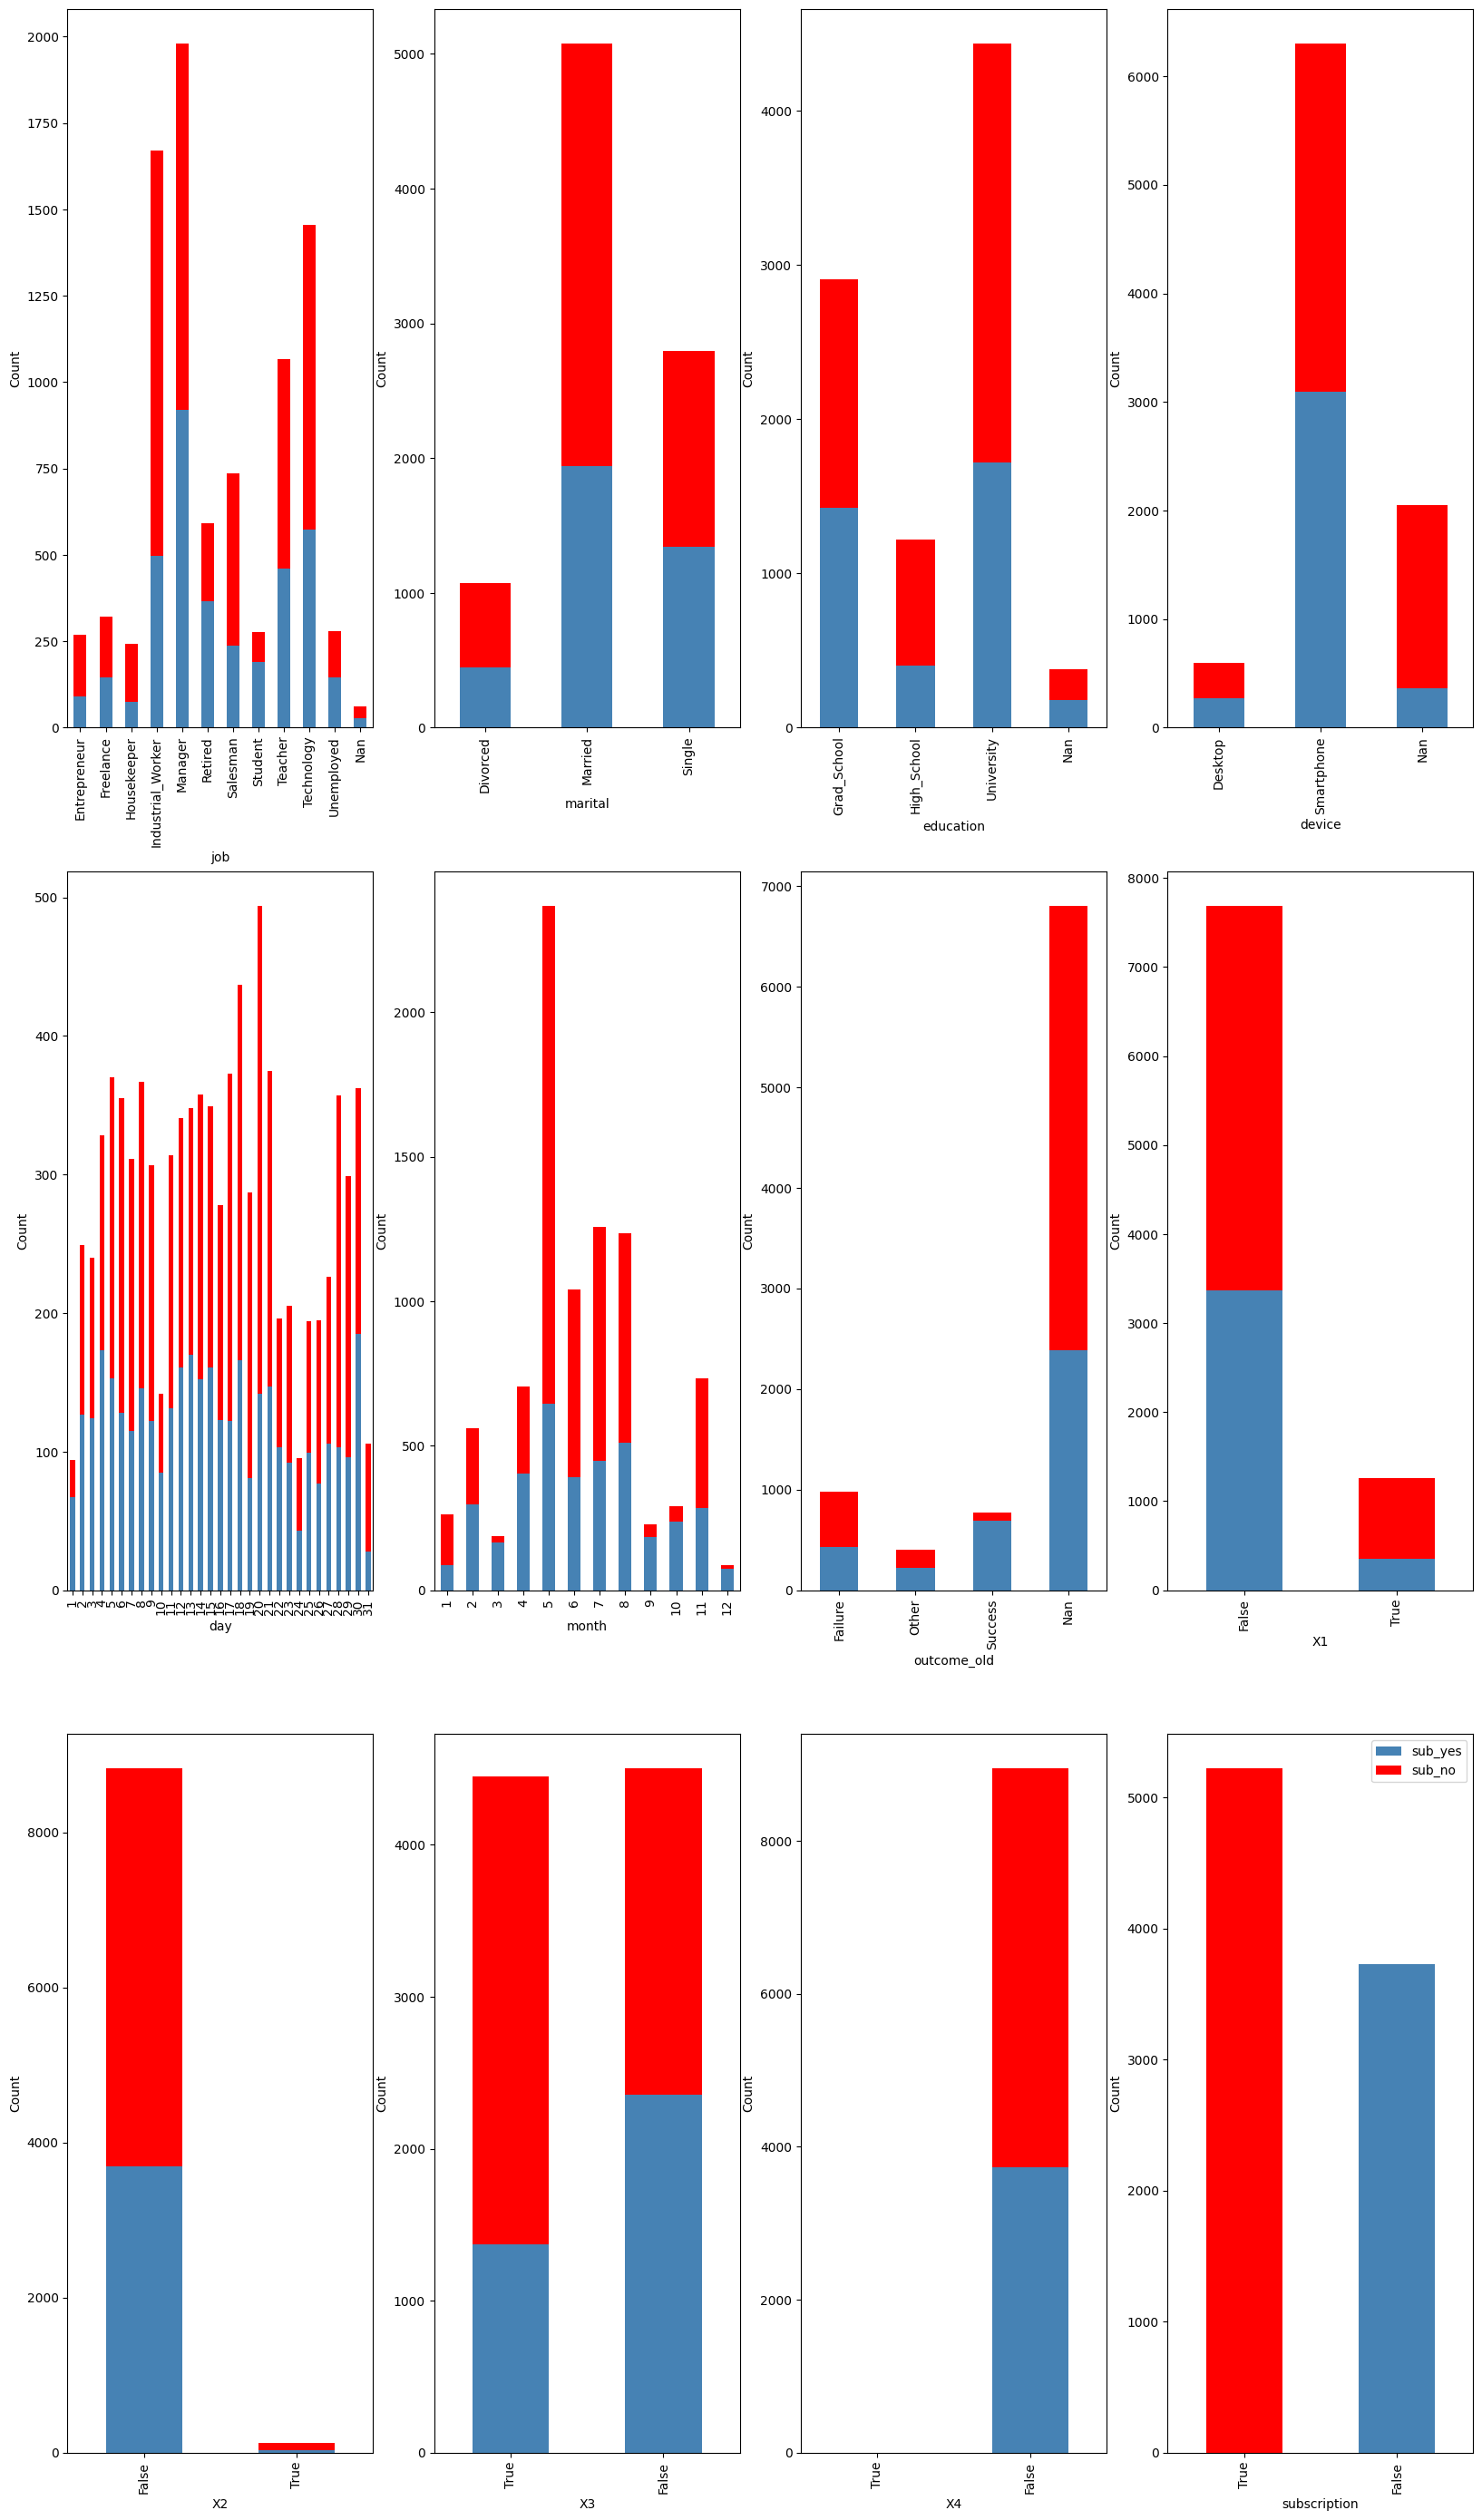

In [22]:
plt.figure(figsize=(20,35))
for i, col in enumerate(categorical_columns_names):
    ax = plt.subplot(3, 4, i+1)
    unique_values = [str(s).title() for s in categorical_columns[col].value_counts(dropna=False, sort=False).index]
    sub_yes = categorical_columns[col][categorical_columns.subscription == True].value_counts(dropna=False, sort=False)
    sub_no = categorical_columns[col][categorical_columns.subscription == False].value_counts(dropna=False, sort=False)
    temp = pd.DataFrame({'unique':unique_values,
                         'sub_yes':sub_yes,
                         'sub_no':sub_no})
    temp.plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax, legend = None)
    plt.xticks(range(len(unique_values)), unique_values, rotation=90)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.legend()
plt.show()

In [ ]:
train_dummy = pd.get_dummies(train)
test_dummy = pd.get_dummies(test)

We see that the target variable is not easily seperable when one uses only two of

## FE

# Predictive model

## Description of best model

## Comparison with other models

## Tuning parameter analysis

## Model selection approach

# Diagnostics and kaggle prediction

## Diagnostics

## Kaggle prediction

# Conclusion